In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd
from forward.fourier.kernel_creator import create_fourier_kernel

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


if torch.cuda.is_available():
    # torch.cuda.set_device(GPU_ID) # Select 5th GPU
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")


%load_ext autoreload
%autoreload 2

5 GPU(s) available:
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090


## Reconstruct FTS measurements

In [2]:
kernel = create_fourier_kernel().unsqueeze(0).permute(0,3,1,2)
undisp_cube, mask, spectras = hlp.create_bs_data(desired_channels=21,kernel=kernel,dir = '20230530_pinhole_data_talbot_0_400us',crop_cube=True,interp_type='average',device='cpu') #here we'll work with synthetic data. 




batch_size = 2


dataset = hlp.KernelLearnerDataset(undispersed_cube=undisp_cube, spectra = spectras,crop=False)

allindexes = np.arange(len(dataset))
np.random.shuffle(allindexes)
tr_indexes = allindexes[:int(0.8*len(allindexes))]
v_indexes = allindexes[int(0.8*len(allindexes)):] 



collecting the undispersed cube and spectra.


In [3]:
train_dl = hlp.CustomDataLoader(dataset, tr_indexes, batch_size=batch_size, shuffle=True)
val_dl = hlp.CustomDataLoader(dataset, v_indexes, batch_size=batch_size, shuffle=True)

In [4]:
model = KernelLearner(kernel=kernel.clone(), padding=8)
model.load_state_dict(torch.load('KernelLearner')); #trained on all data.
model.to('cpu')
model.kernel = model.kernel.to('cpu')

In [7]:
x,y  = dataset[[0,1]]
x = x
y_pred = model(x)

trained_kernel = model.fill_kernel()

Text(0.5, 1.0, 'Trainable region')

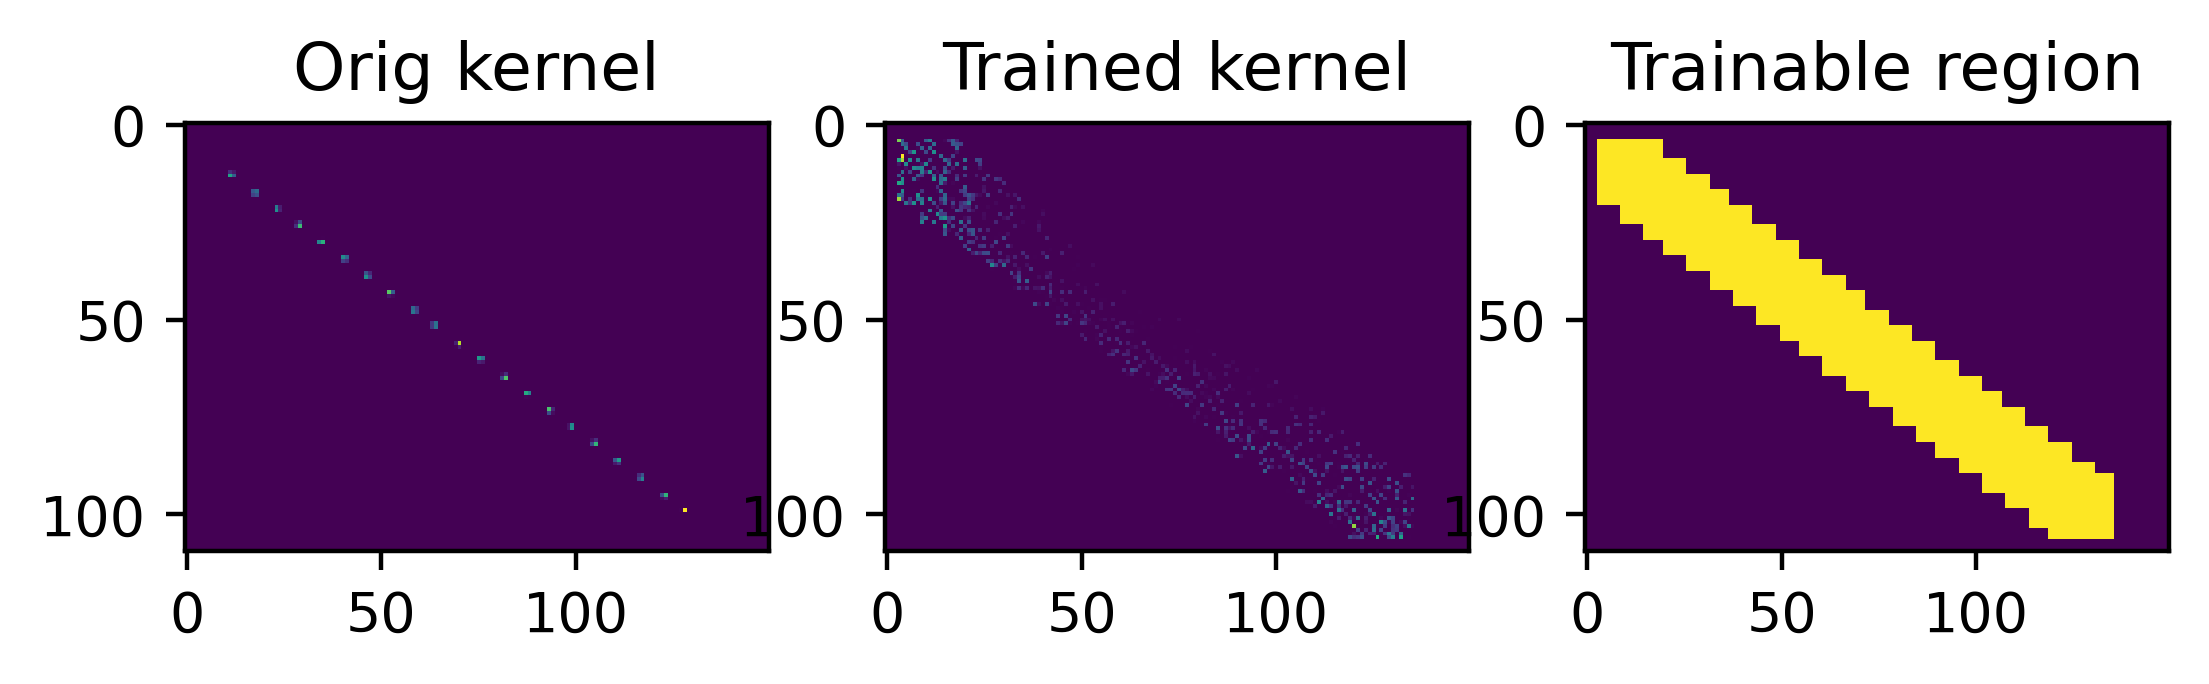

In [8]:
bx = [625,735]
by = [850,1000]

fig,ax = plt.subplots(1,3,dpi=400)
ax[0].imshow(torch.sum(kernel[0],dim=0)[bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[0].set_title('Orig kernel')
ax[1].imshow(torch.sum(trained_kernel[0],dim=0)[bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[1].set_title('Trained kernel')
ax[2].imshow((np.sum(model.locations,axis=0)>0)[bx[0]:bx[1],by[0]:by[1]]); ax[2].set_title('Trainable region')

In [13]:
model.locations.shape

(21, 2048, 2448)

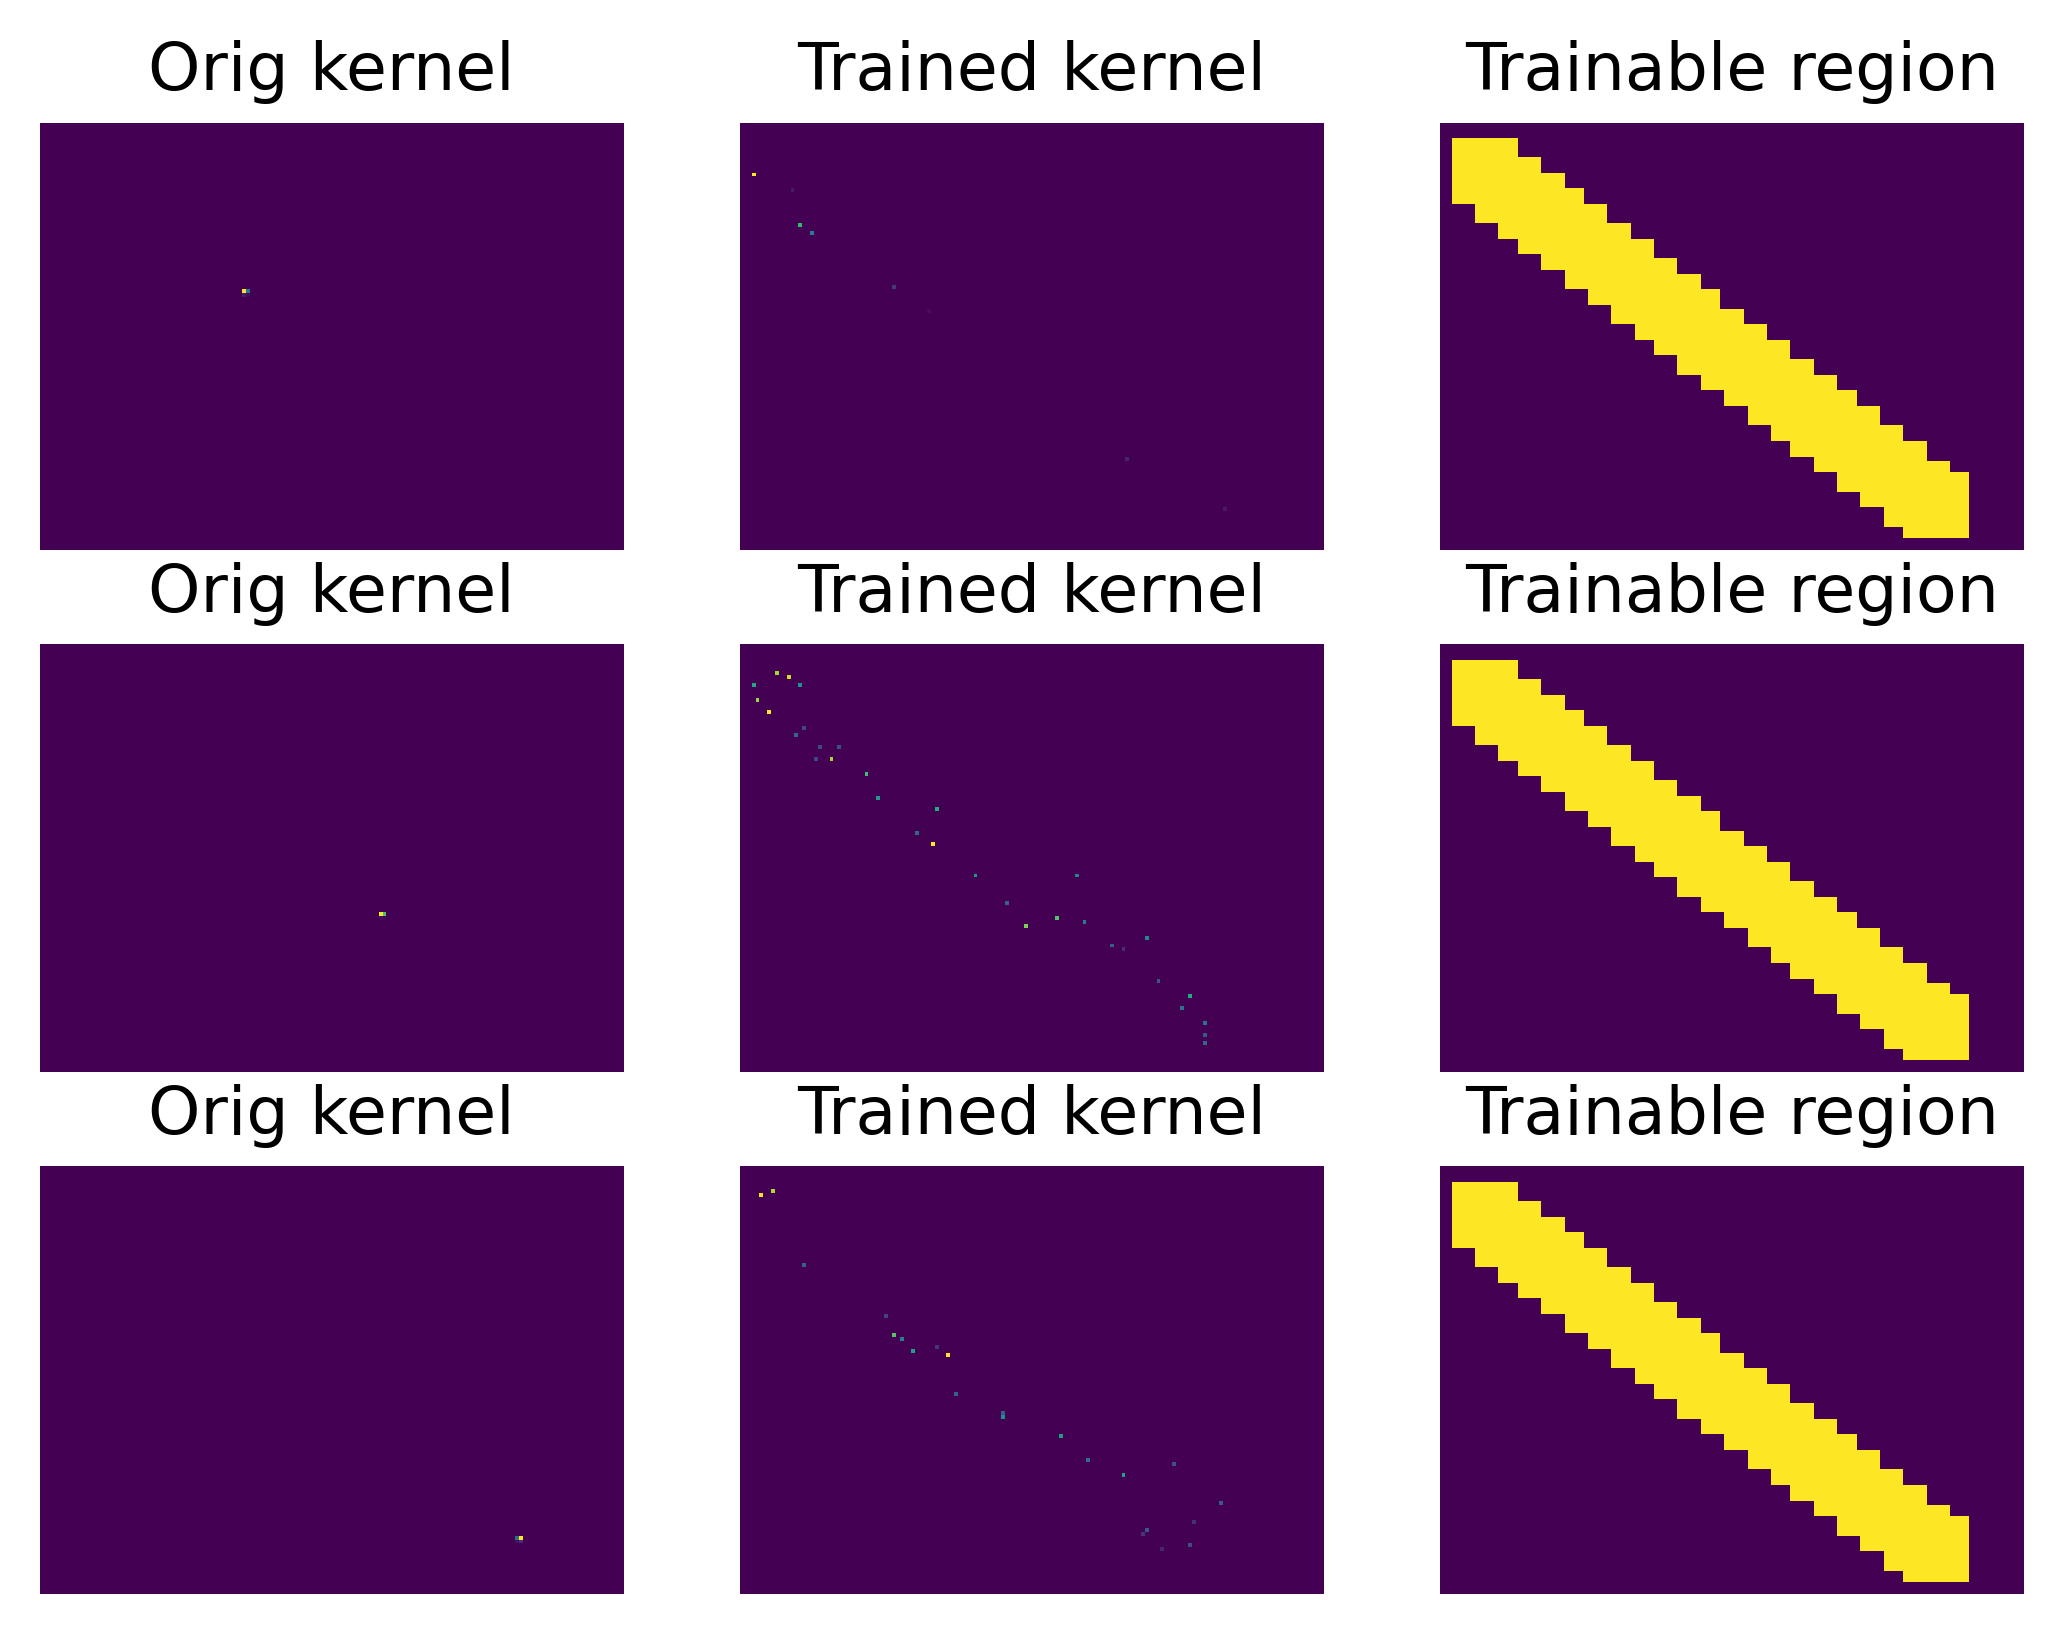

In [14]:
l  = [7,13,19]

fig,ax = plt.subplots(3,3,dpi=400)
for i in range(3):

    ax[i,0].imshow(kernel[0,l[i]][bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[i,0].set_title('Orig kernel'); ax[i,0].set_axis_off()
    ax[i,1].imshow(trained_kernel[0,l[i]][bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[i,1].set_title('Trained kernel'); ax[i,1].set_axis_off()
    ax[i,2].imshow((model.locations[l[i]]>0)[bx[0]:bx[1],by[0]:by[1]]); ax[i,2].set_title('Trainable region'); ax[i,2].set_axis_off()

## Try training with a total variation loss on the kernel?

In [ ]:
kernel = kernel.to('cuda')

In [11]:
model = KernelLearner(kernel=kernel.clone(), padding=8).to('cuda')
# model.load_state_dict(torch.load('KernelLearner')); #trained on all data.
# model.to('cpu')
# model.kernel = model.kernel.to('cpu')

lr = 5e-4
epochs = 10
device = 'cuda:0'

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = TVLoss(mse_weight=1, tv_weight=10000)

metric = torch.nn.MSELoss()

In [12]:
model_name = model.name
lr = optimizer.param_groups[0]['lr']

print('train called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
        (model_name, type(optimizer).__name__,
        lr, epochs, device))

history = {} # Collects per-epoch loss and acc like Keras' fit().
history['loss'] = []
history['val_loss'] = []
history['acc'] = []
history['val_acc'] = []

total_batches = int(len(train_dl.indexes)/train_dl.batch_size)

start_time_sec = time.time()

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    model.train()
    train_loss         = 0.0
    train_mse         = 0.0
    num_train_examples = 0

    for n,(x,y) in enumerate(train_dl):

        optimizer.zero_grad()

        x    = x.to(device,dtype=torch.float32)
        y    = y.to(device,dtype=torch.float32)
        yhat = model(x)
        loss = loss_fn(yhat, y, model)

        loss.backward()
        optimizer.step()

        train_loss         += loss.data.item() * x.size(0)
        num_train_examples += x.shape[0]
        
        mse = metric(yhat, y)
        train_mse         += mse.data.item() * x.size(0)

        print(f'Epoch {epoch}/{epochs}: ({n}/{total_batches}), train loss: {(train_loss/num_train_examples):5.5g}, train mse: {(train_mse/num_train_examples):5.5g}',end='\r')

    train_loss  = train_loss / len(train_dl.indexes)


    # --- EVALUATE ON VALIDATION SET -------------------------------------
    model.eval()
    with torch.no_grad():
        val_loss       = 0.0
        val_mse = 0.0
        num_val_examples = 0

        for n,(x,y) in enumerate(val_dl):

            x    = x.to(device,dtype=torch.float32)
            y    = y.to(device,dtype=torch.float32)
            yhat = model(x)
            loss = loss_fn(yhat, y, model)

            val_loss         += loss.data.item() * x.size(0)
            num_val_examples += y.shape[0]

            mse = metric(yhat, y)
            val_mse         += mse.data.item() * x.size(0)

        val_loss = val_loss / len(val_dl.indexes)
        val_mse = val_mse / len(val_dl.indexes)

    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}: ({total_batches}/{total_batches}), train loss: {train_loss:5.5g}, val_loss = {val_loss:5.5g}, val_met= {val_mse:5.5g}  epoch time: {total_time_sec:5.5g}')


    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    
with open('model_results.txt', 'a') as file:
    file.write(f'model={model_name}, lr = {lr}, epochs = {epochs}\n')
    file.write(f'epoch time: {total_time_sec}\n')
    file.write(f'history: {history}\n')
    file.write('\n\n\n')

train called: model=KernelLearner, opt=Adam(lr=0.000500), epochs=10, device=cuda:0

Epoch 1/10: (1199/1199), train loss: 34.842, val_loss = 9.6652, val_met= 6.0897  epoch time: 366.28
Epoch 2/10: (1199/1199), train loss: 3.7976, val_loss = 0.89807, val_met= 0.38355  epoch time: 366.47
Epoch 3/10: (1199/1199), train loss: 0.35708, val_loss = 0.12388, val_met= 0.017438  epoch time: 365.74
Epoch 4/10: (1199/1199), train loss: 0.079418, val_loss = 0.050628, val_met= 0.0047815  epoch time: 365.9
Epoch 5/10: (1199/1199), train loss: 0.033229, val_loss = 0.019018, val_met= 0.0035587  epoch time: 368.28
Epoch 6/10: (1199/1199), train loss: 0.011073, val_loss = 0.0058067, val_met= 0.0032551  epoch time: 368.33
Epoch 7/10: (1199/1199), train loss: 0.0041597, val_loss = 0.0034333, val_met= 0.0032838  epoch time: 365.75
Epoch 8/10: (1199/1199), train loss: 0.0033456, val_loss = 0.0033385, val_met= 0.0033079  epoch time: 365.81
Epoch 9/10: (1199/1199), train loss: 0.0033253, val_loss = 0.0033382, v

In [13]:
trained_kernel = model.fill_kernel()

Text(0.5, 1.0, 'Trainable region')

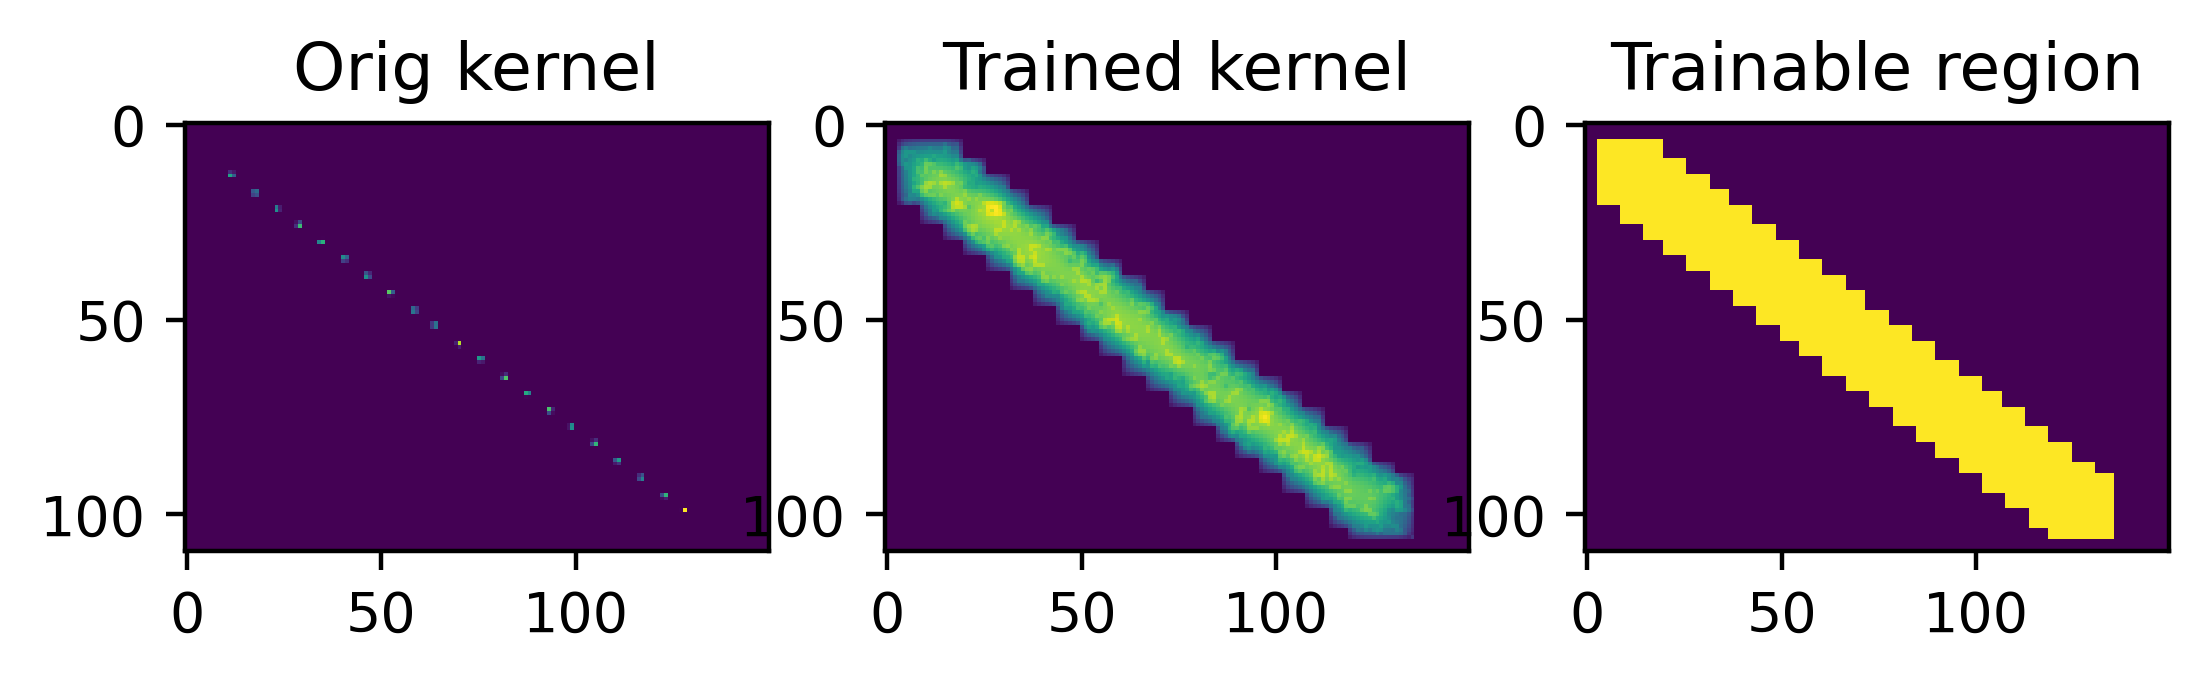

In [14]:
bx = [625,735]
by = [850,1000]

fig,ax = plt.subplots(1,3,dpi=400)
ax[0].imshow(torch.sum(kernel[0],dim=0)[bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[0].set_title('Orig kernel')
ax[1].imshow(torch.sum(trained_kernel[0],dim=0)[bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[1].set_title('Trained kernel')
ax[2].imshow((np.sum(model.locations,axis=0)>0)[bx[0]:bx[1],by[0]:by[1]]); ax[2].set_title('Trainable region')

Text(0.5, 1.0, 'Trainable region')

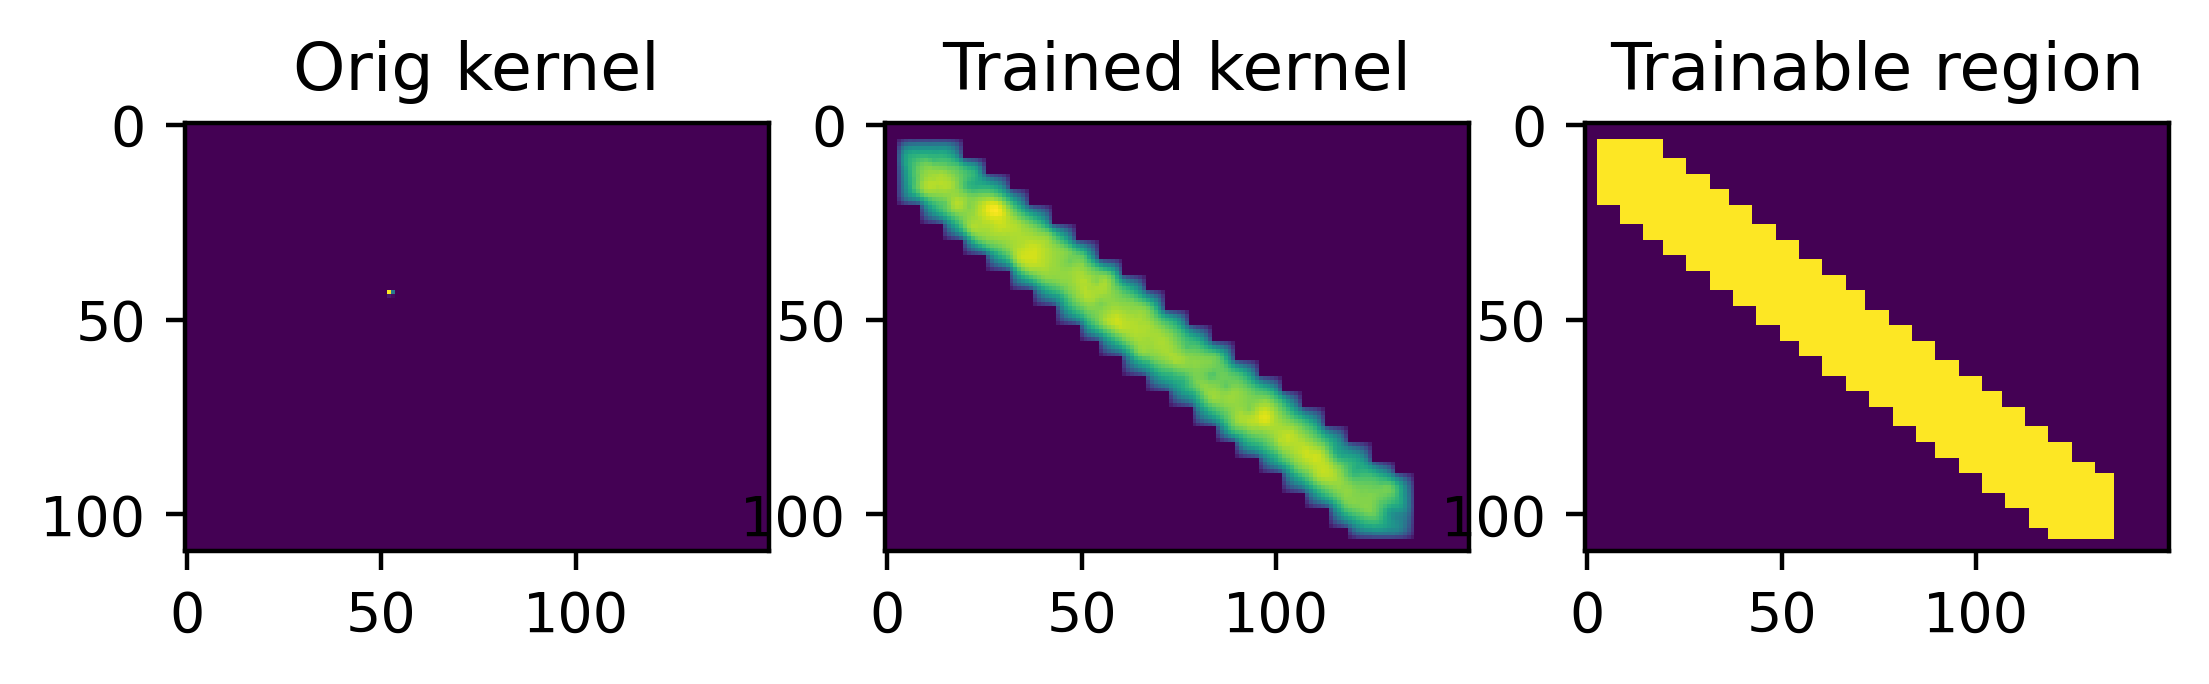

In [15]:
l  = 7

fig,ax = plt.subplots(1,3,dpi=400)
ax[0].imshow(kernel[0,l][bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[0].set_title('Orig kernel')
ax[1].imshow(trained_kernel[0,l][bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[1].set_title('Trained kernel')
ax[2].imshow((np.sum(model.locations,axis=0)>0)[bx[0]:bx[1],by[0]:by[1]]); ax[2].set_title('Trainable region')